In [2]:
import rasterio
import geopandas as gpd
import numpy as np

from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from shapely.geometry import box

In [1]:
shapefile_path = 'ml-mangrove-data2/label.shp'
shapefile = gpd.read_file(shapefile_path)
print("Shapefile CRS:", shapefile.crs)

Shapefile CRS: EPSG:4326


In [22]:
# Define the input and output TIFF file paths
input_tiff = 'scaled_train.tif'  # Path to your EPSG:32618 TIFF file
output_tiff = 'train.tif'  # Desired path for your EPSG:4326 TIFF file

# Define the new CRS
new_crs = 'EPSG:4326'  # WGS 84

# Open the input TIFF file
with rasterio.open(input_tiff) as src:
    # Calculate the transformation and new dimensions
    transform, width, height = calculate_default_transform(
        src.crs, new_crs, src.width, src.height, *src.bounds)
    
    # Define the metadata for the output file
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': new_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Create and write the output file
    with rasterio.open(output_tiff, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):  # Iterate through bands
            # Reproject and write each band
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=new_crs,
                resampling=Resampling.nearest)


In [23]:
raster_path = 'train.tif'
with rasterio.open(raster_path) as src:
    raster_bounds = src.bounds
    tiff_crs = src.crs
    print("TIFF CRS:", tiff_crs)


TIFF CRS: EPSG:4326


In [4]:
bbox = gpd.GeoDataFrame({'geometry': [box(*raster_bounds)]}, crs=src.crs)
clipped_shapefile = gpd.overlay(shapefile, bbox, how='intersection')

In [5]:
print("Before removal of non-finite geometries:", len(shapefile))

# Check for non-finite values in the geometry column
finite_geometries_mask = shapefile.geometry.apply(lambda geom: np.isfinite(geom.bounds).all())
shapefile_reprojected = shapefile[finite_geometries_mask]

print("After removal of non-finite geometries:", len(shapefile))

Before removal of non-finite geometries: 4238878
After removal of non-finite geometries: 4238878


In [6]:
# Define the path for the new shapefile
new_shapefile_path = 'ml-mangrove-data2/resizeLabel.shp'

# Save the clipped shapefile to a new shapefile
clipped_shapefile.to_file(new_shapefile_path)


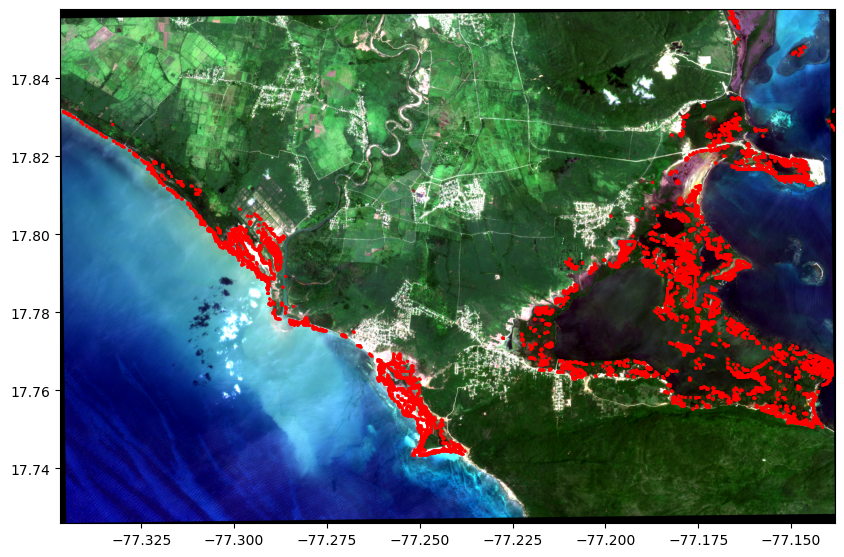

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
[0.         0.00266183 0.00345472 ... 0.99433655 0.9974514  1.        ]
[1.9066164e+09]


In [7]:
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd

# Step 1: Read the TIFF file
with rasterio.open('train.tif') as src:
    # Read the first three bands
    rgb_data = src.read([1, 2, 3])
    ir_data = src.read(4)

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(10, 10))

    # Show the RGB data
    show(rgb_data.astype(np.uint8), ax=ax, transform=src.transform)

# Step 2: Read the shapefile
shapefile_path = 'ml-mangrove-data2/resizeLabel.shp'
shapefile = gpd.read_file(shapefile_path)

# Step 4: Plot the shapefile on top of the TIFF
shapefile.boundary.plot(ax=ax, color='red', linewidth=2)

plt.show()
print(rgb_data)
print(np.unique(ir_data))
print(np.unique(np.sum(rgb_data[0, :, :])))



[ 1272  1292  1300 ... 23798 23819 23854]
[ 2524  2525  2526 ... 25173 25198 25313]
[[[5.3000000e+01 5.8000000e+01 6.1000000e+01 ... 4.4000000e+01
   4.4000000e+01 4.4000000e+01]
  [5.2000000e+01 5.8000000e+01 6.2000000e+01 ... 4.5000000e+01
   4.2000000e+01 3.7000000e+01]
  [5.2000000e+01 5.9000000e+01 6.3000000e+01 ... 4.6000000e+01
   4.2000000e+01 3.7000000e+01]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 5.0000000e+01
   4.7000000e+01 4.5000000e+01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 5.1000000e+01
   4.6000000e+01 3.8000000e+01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 5.3000000e+01
   5.0000000e+01 3.9000000e+01]]

 [[1.1400000e+02 1.1700000e+02 1.1400000e+02 ... 7.2000000e+01
   6.9000000e+01 6.7000000e+01]
  [1.1200000e+02 1.1500000e+02 1.1500000e+02 ... 7.3000000e+01
   7.1000000e+01 6.8000000e+01]
  [1.0900000e+02 1.1500000e+02 1.1600000e+02 ... 7.2000000e+01
   7.1000000e+01 7.0000000e+01]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ..

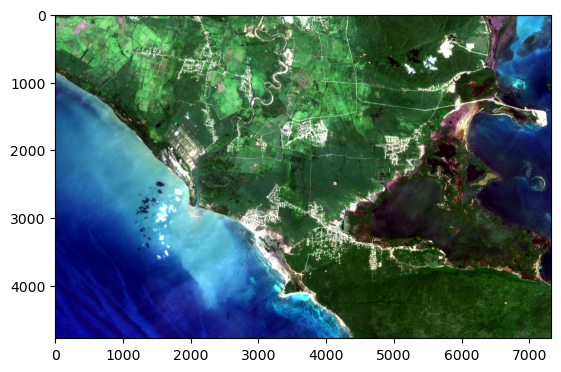

In [17]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np
import sys
import matplotlib.pyplot as plt

# Open the raster data
with rasterio.open('crop.tif') as src:
    data = src.read()
    meta = src.meta.copy()

data[[0, 2], :, :] = data[[2, 0], :, :]
print(np.unique(data[0, :, :]))
print(np.unique(data[1, :, :]))
# Placeholder min and max values for each band based on QGIS
# Replace these with your actual min and max values
min_band1, max_band1 = 1509, 4389
min_band2, max_band2 = 2971, 5737
min_band3, max_band3 = 4189, 6394

# Assuming 'data' is your 3D numpy array with shape [bands, height, width]
scaled_data = np.empty(data.shape, dtype=np.float32)
# Apply contrast stretching separately for each band
for i, (min_val, max_val) in enumerate(zip([min_band1, min_band2, min_band3], 
                                           [max_band1, max_band2, max_band3])):
    scaled_data[i, :, :] = ((np.clip(data[i, :, :], min_val, max_val) - min_val) / (max_val - min_val)) * 255.0
    scaled_data[i, :, :] = scaled_data[i, :, :].astype(np.uint8)
min_val = np.min(data[3, :, :])
max_val = np.max(data[3, :, :])
scaled_data[3, :, :] = (data[3, :, :] - min_val) / (max_val - min_val)
print(scaled_data)
rgb_data = scaled_data[:3, :, :]

# Transpose the data to get it into (height, width, bands) format for imshow
rgb_image = rgb_data.transpose(1, 2, 0)

# Display the image
plt.imshow(rgb_image.astype(np.uint8))
plt.show()

meta.update({
    'dtype': 'float32',
    'count': scaled_data.shape[0],  # Number of bands
    'height': scaled_data.shape[1],  # Height of the image
    'width': scaled_data.shape[2],  # Width of the image
})
with rasterio.open('scaled_train.tif', 'w', **meta) as dst:
    dst.write(scaled_data)

In [14]:
with rasterio.open('2019-image/8.tiff') as src:
    tiff_crs = src.crs
    data = src.read()
    print("TIFF CRS:", tiff_crs)
    print(data)

TIFF CRS: EPSG:4326
[[[2.657e-01 2.637e-01 2.404e-01 ... 2.500e-03 3.300e-03 3.100e-03]
  [2.309e-01 2.491e-01 2.445e-01 ... 1.700e-03 2.700e-03 1.900e-03]
  [2.272e-01 2.260e-01 2.408e-01 ... 2.300e-03 3.100e-03 2.100e-03]
  ...
  [9.000e-04 1.100e-03 7.000e-04 ... 7.000e-04 1.500e-03 2.300e-03]
  [1.000e-04 6.000e-04 5.000e-04 ... 1.700e-03 2.500e-03 1.800e-03]
  [0.000e+00 1.700e-03 1.200e-03 ... 3.100e-03 3.500e-03 1.900e-03]]]


In [10]:
#Transform DEM 

with rasterio.open('DEM_30m.tif') as src2:
        ele_data = src2.read()
        transform, width, height = calculate_default_transform(
            src2.crs, src.crs, src2.width, src2.height, *src2.bounds)
        # Define the metadata for the reprojected file
        kwargs = src2.meta.copy()
        kwargs.update({
            'crs': src.crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        
        # Create the reprojected raster
        with rasterio.open('reprojected_DEM_30m.tif', 'w', **kwargs) as dst:
            for i in range(1, src2.count + 1):
                reproject(
                    source=rasterio.band(src2, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src2.transform,
                    src_crs=src2.crs,
                    dst_transform=transform,
                    dst_crs=src.crs,
                    resampling=Resampling.nearest)

In [16]:
with rasterio.open('DEM_30m.tif') as src:
    tiff_crs = src.crs
    print("TIFF CRS:", tiff_crs)
with rasterio.open('reprojected_DEM_30m.tif') as src:
    tiff_crs = src.crs
    print("TIFF CRS:", tiff_crs)

TIFF CRS: EPSG:4326
TIFF CRS: EPSG:4326


In [15]:
# Open the first TIFF file
with rasterio.open('train.tif') as src1:
    bounds1 = src1.bounds
    crs1 = src1.crs

# Open the second TIFF file
with rasterio.open('DEM_30m.tif') as src2:
    bounds2 = src2.bounds
    crs2 = src2.crs
print(crs1)
print(crs2)
#Convert bounds to shapely geometry
box1 = box(*bounds1)
box2 = box(*bounds2)

# Find intersection
intersection = box1.intersection(box2)

# Ensure the intersection is in the same CRS as the TIFFs
intersection_gdf = gpd.GeoDataFrame({'geometry': [intersection]}, crs=crs1)

# Reproject intersection if the CRS are different
if crs1 != crs2:
    intersection_gdf = intersection_gdf.to_crs(crs2)

# Clip the second TIFF using the intersection
with rasterio.open('DEM_30m.tif') as src2:
    out_image, out_transform = mask(src2, intersection_gdf.geometry, crop=True)
    out_meta = src2.meta.copy()

# Update the metadata with the new dimensions and transformation
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Save the clipped area as a new TIFF
with rasterio.open('reprojected_DEM_30m.tif', "w", **out_meta) as dest:
    dest.write(out_image)


EPSG:4326
EPSG:4326


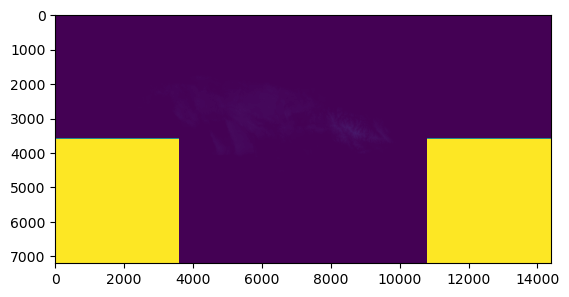

EPSG:4326
EPSG:32618


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


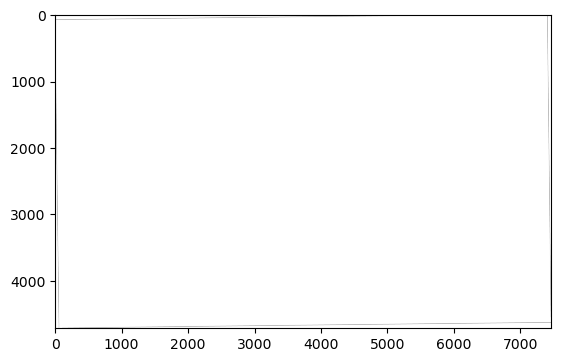

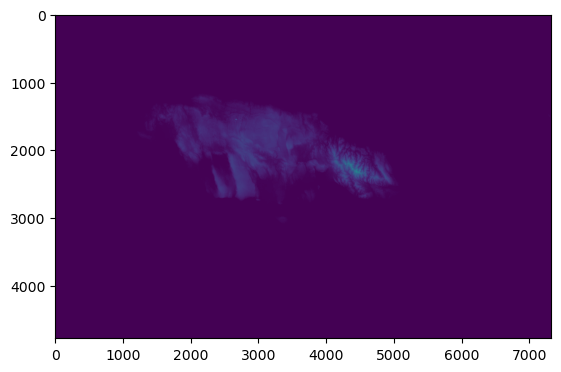

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
Unique values in the array: [    0  3885  3887 ... 26111 26150 26159]
Unique values in the array: [    0  2524  2525 ... 25173 25198 25313]
Unique values in the array: [    0  1272  1292 ... 23798 23819 23854]
Unique values in the array: [    0   197   244 ... 17754 17809 17854]


In [12]:
import rasterio
import numpy as np
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject
from rasterio.plot import show

# Open the 3m resolution TIFF
with rasterio.open('crop.tif') as dataset_3m:
    # Open the 30m resolution TIFF
    with rasterio.open('DEM_30m.tif') as dataset_30m:
        ele = dataset_30m.read()
        show(ele)  # Show the first band of the aligned second TIFF
        print(dataset_30m.crs)
        print(dataset_3m.crs)
        # Calculate the transformation and new width and height
        transform, width, height = calculate_default_transform(
            dataset_30m.crs, dataset_3m.crs, 
            dataset_30m.width, dataset_30m.height, 
            *dataset_30m.bounds,
            dst_width=dataset_3m.width,
            dst_height=dataset_3m.height
        )
        
        # Define the metadata for the new resampled file
        kwargs = dataset_30m.meta.copy()
        kwargs.update({
            'crs': dataset_3m.crs,
            'transform': transform,
            'width': width,
            'height': height,
            'nodata': dataset_30m.nodata
        })
        
        # Create and write the resampled data to a new file
        with rasterio.open('reprojected_DEM_30m.tif', 'w', **kwargs) as dst:
            for i in range(1, dataset_30m.count + 1):
                reproject(
                    source=rasterio.band(dataset_30m, i),
                    destination=rasterio.band(dst, i),
                    src_transform=dataset_30m.transform,
                    src_crs=dataset_30m.crs,
                    dst_transform=transform,
                    dst_crs=dataset_3m.crs,
                    resampling=Resampling.bilinear
                )
with rasterio.open('reprojected_DEM_30m.tif') as src:
    # Read the first band (or the specific band you want to modify)
    band = src.read(1)
    
    # Replace values of 32000 with 0
    band[band == 32767] = 0
    
    # Copy the metadata from the source file
    meta = src.meta

# Write the modified array back to a new TIFF file
with rasterio.open('reprojected_DEM_30m.tif', 'w', **meta) as dst:
    dst.write(band, 1)

with rasterio.open('train.tif') as src:
    train_data = src.read()
    show(train_data)
with rasterio.open('reprojected_DEM_30m.tif') as src:
    ele_data = src.read()
show(ele_data)  # Show the first band of the aligned second TIFF
print(ele_data)

unique_values = np.unique(train_data[0])
print("Unique values in the array:", unique_values)
unique_values = np.unique(train_data[1])
print("Unique values in the array:", unique_values)
unique_values = np.unique(train_data[2])
print("Unique values in the array:", unique_values)
unique_values = np.unique(train_data[3])
print("Unique values in the array:", unique_values)
